# 0. Set Objectives

The main objective of this notebook is to provide a proof of concept of a Physics-Informed Neural Network (PINN) to provide a numerical solution to the Dirichlet problem for the Monge-Ampere elliptic equation in 2D. The exemple discussed here is the first test problem exposed in Alexandre Caboussat, Roland Glowinski and Danny C. Sorensen's paper: A least-squares method for the numerical solution of the dirichlet problem for the elliptic Monge-Ampère equation in dimension two. 2013.


The PDE & Dirichlet Boundary Condition are characterized as follow:
$$det \textbf{D}^2 \psi(x_{1},x_{2}) = 1, \forall(x_{1},x_{2})\in \Omega = (0,1)^2$$

$$\psi(x_{1},x_{2}) = \frac{5}{2} x_{1}^2 + 2 x_{1} x_{2} + \frac{1}{2}x_{2}^2, \forall(x_{1},x_{2})\in \Gamma$$

$det \textbf{D}^2 \psi(x_{1},x_{2})$ will be defined as follow:

$$det \textbf{D}^2 \psi(x_{1},x_{2}) = \left(\frac{\partial ^2\psi}{\partial x_{1}^2} \frac{\partial ^2\psi}{\partial x_{2}^2}- \left(\frac{\partial ^2\psi}{\partial x_{1}\partial x_{2}}\right)^2 \right)(x_{1},x_{2}) $$

Based on DeepXDE library with Tensorflow backend for the implementation, the PINN architecture is highly inspired by the following papers:

- Maziar Raissi, Paris Perdikaris, and George E Karniadakis. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. 2017.

- Jialin Chen. Numerical Methods and Deep Learning Frameworks for Solving Monge-Ampere Equation. 2021. 

- Lu Lu, Xuhui Meng, Zhiping Mao, George Em Karniadakis. DeepXDE: A Deep Learning Library for Solving Differential Equations. 2021

The notebbok is structured as follow:

- 0. Set Objective
- 1. Work environnement management
- 2. True solution visualization
- 3. Define PDE, BC, domaine
- 4. Define PINN
- 5. Evaluate PINN

Several points remain to be confirmed such as:
- Data sampling size impact
- FNN architecture impact
- Activation function impact
- PINN Robustness
- Convergence to local minima
- ...

## 1.1.Manage virtual env

## 1.2. Import python libraries

In [24]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
import deepxde as dde

# 2. PDE true solution visualization

In [25]:
x = np.random.uniform(0, 1, 1000)
y = np.random.uniform(0, 1, 1000)

z = 2.5 * np.square(x) + 2 * x * y + .5 * np.square(y)

In [26]:
df = pd.DataFrame(np.vstack((x, y, z)).T, columns=['x', 'y', 'z'])

In [27]:
fig = go.Figure(go.Mesh3d(x=df['x'], y=df['y'], z=df['z'], intensity=df['z'], colorscale='Viridis'))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    showlegend=False
)

fig.show()

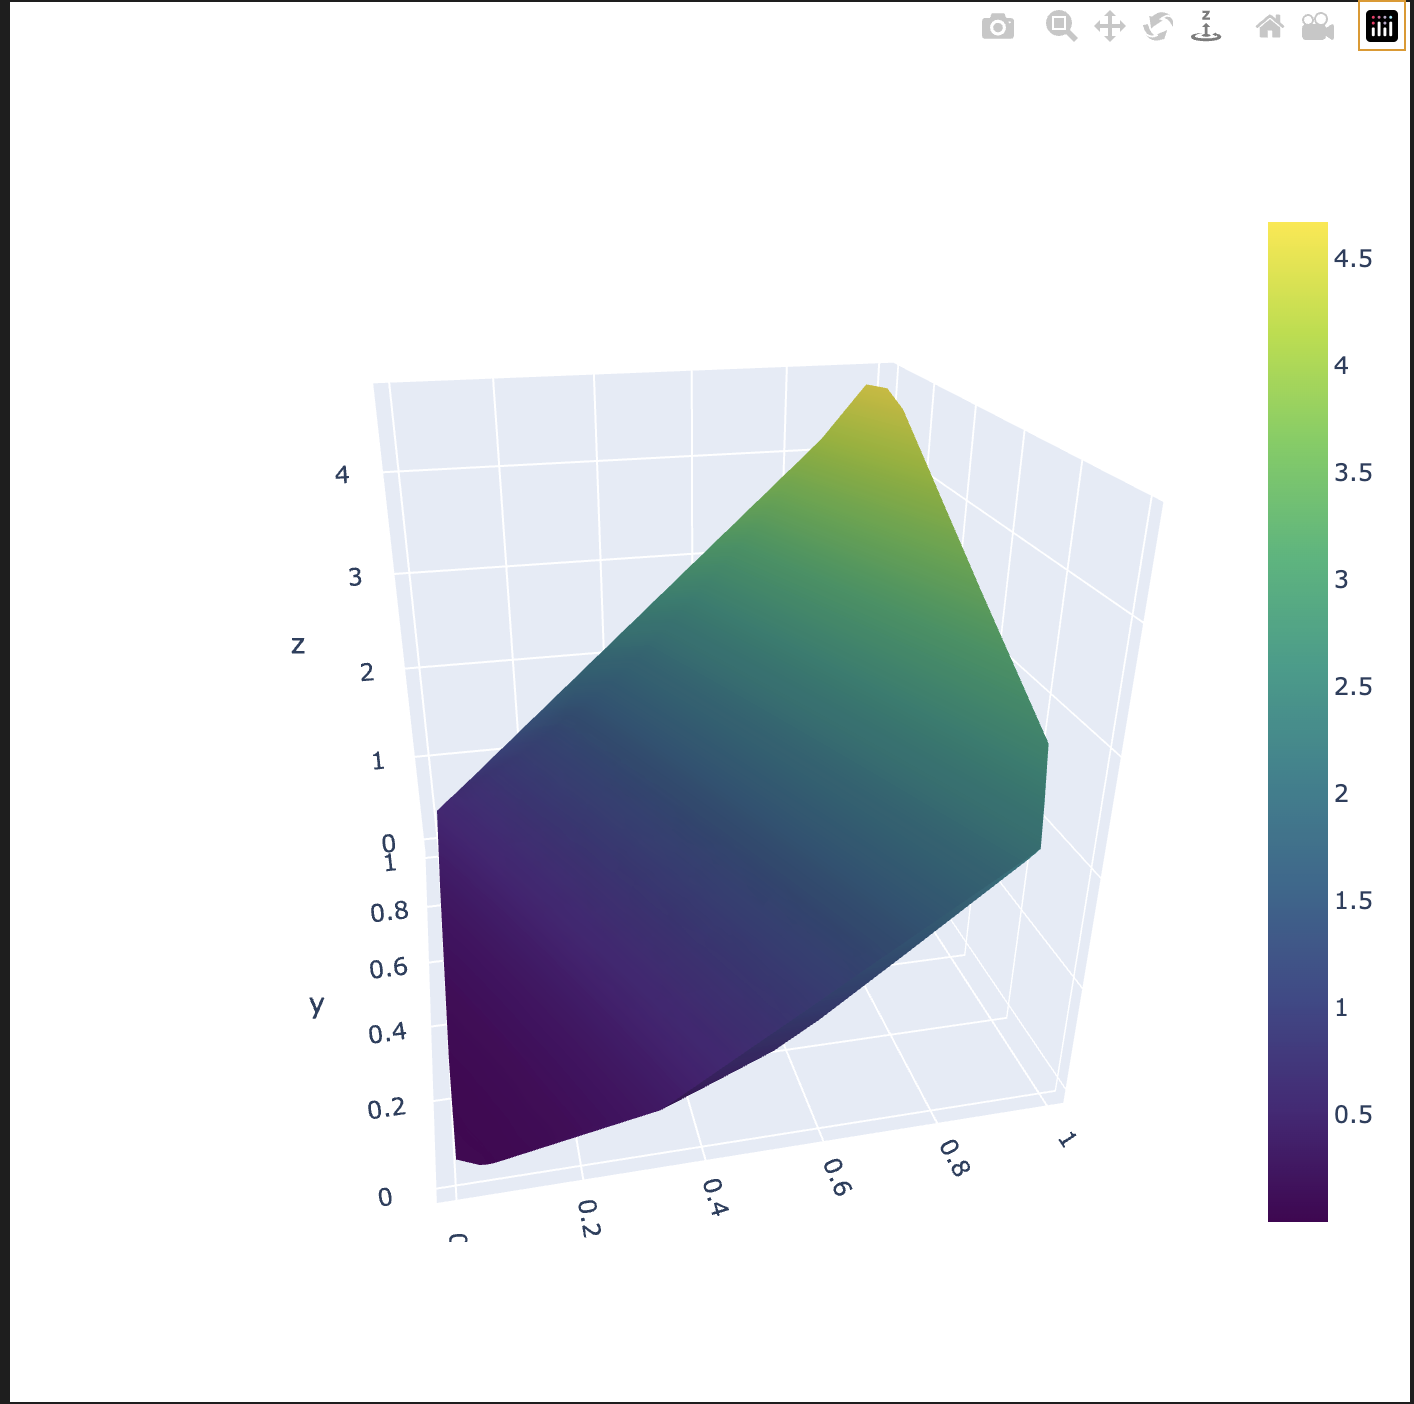

# 3. Define PDE, BC and domains

### First Test Problem

In [28]:
def pde(x, u):
    f = 1
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)

    du_xy = dde.grad.hessian(u, x, i=0, j=1)
    
    return du_xx * du_yy - du_xy ** 2 - f

In [29]:
#Define DirichletBC
def func(X):
    x, y = X[:, 0:1], X[:, 1:]
    return (5 / 2 * x**2 + 2 * x * y + 1 / 2 * y**2)

In [30]:
#Define where BC are applied
def boundary(_, on_boundary):
    return on_boundary

In [31]:
#Define problem's geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])

In [32]:
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.pde.PDE(geom,pde,bc, num_domain= 2500, num_boundary= 2500)

# 4. Define PINN

In [33]:
layer_size = [2] + [128] * 5 + [1]
activation = 'sigmoid'
initializer = "Glorot uniform"

net = dde.nn.tensorflow_compat_v1.fnn.FNN(layer_size, activation, initializer)
model = dde.model.Model(data, net)
model.compile('adam', lr=.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.031811 s



/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

2023-02-16 18:42:52.742770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 18:42:52.742793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'compile' took 0.605805 s



In [34]:
losshistory, train_state = model.train(iterations=1000)

Initializing variables...
Training model...



2023-02-16 18:42:53.387211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 18:42:53.465919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 18:42:53.742687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0         [1.00e+00, 5.57e+00]    [1.00e+00, 5.57e+00]    []  


2023-02-16 18:42:54.069891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1000      [3.48e-04, 8.50e-04]    [3.48e-04, 8.50e-04]    []  

Best model at step 1000:
  train loss: 1.20e-03
  test loss: 1.20e-03
  test metric: []

'train' took 30.061692 s



Saving loss history to /Users/adrien/Desktop/HEG_Candidature_Pereira_Adrien/PINN_Monge_Ampere/First Test/loss.dat ...
Saving training data to /Users/adrien/Desktop/HEG_Candidature_Pereira_Adrien/PINN_Monge_Ampere/First Test/train.dat ...
Saving test data to /Users/adrien/Desktop/HEG_Candidature_Pereira_Adrien/PINN_Monge_Ampere/First Test/test.dat ...


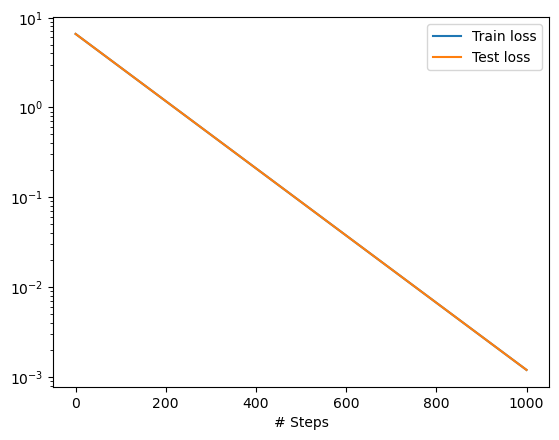

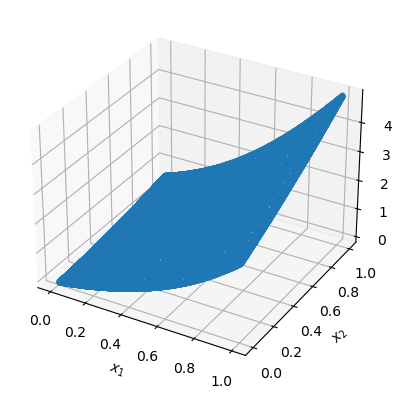

In [35]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# 5. Evaluate PINN

In [36]:
x = np. linspace(0, 1, 100)
y = np. linspace(0, 1, 100)

test_x , test_y= np.meshgrid(x, y)
test_domain =  np.vstack((np.ravel(test_x), np.ravel(test_y))).T
domain_x = test_domain[:, :1]
domain_y = test_domain[:, 1:2]

predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

true = 2.5*np.square(domain_x) + 2*domain_x*domain_y + .5*np.square(domain_y)
error = true - predicted_solution

RMSE = np.sqrt(np.sum(np.square(error))/len(true))
MAE = np.sum(np.abs(error))/len(true)

print(f'RMSE: {RMSE}')
print(f'MAE: {MAE}')

2023-02-16 18:43:23.737958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 18:43:23.839614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


RMSE: 0.02257465876822813
MAE: 0.016951267504372234


In [37]:
df = pd.DataFrame(np.hstack((test_domain, true, predicted_solution, residual, error)), columns=['x', 'y', 'true', 'predicted_solution', 'residual', 'error'])

In [40]:
mesh_true = go.Mesh3d(x=df['x'], y=df['y'], z=df['true'], color='blue')
mesh_pred = go.Mesh3d(x=df['x'], y=df['y'], z=df['predicted_solution'], color='red')
fig = go.Figure(data=[mesh_true, mesh_pred])

fig.update_layout(
    autosize=False,
    width=750,
    height=750,
    title='predicted & true solutions comparison'
)

fig.show()

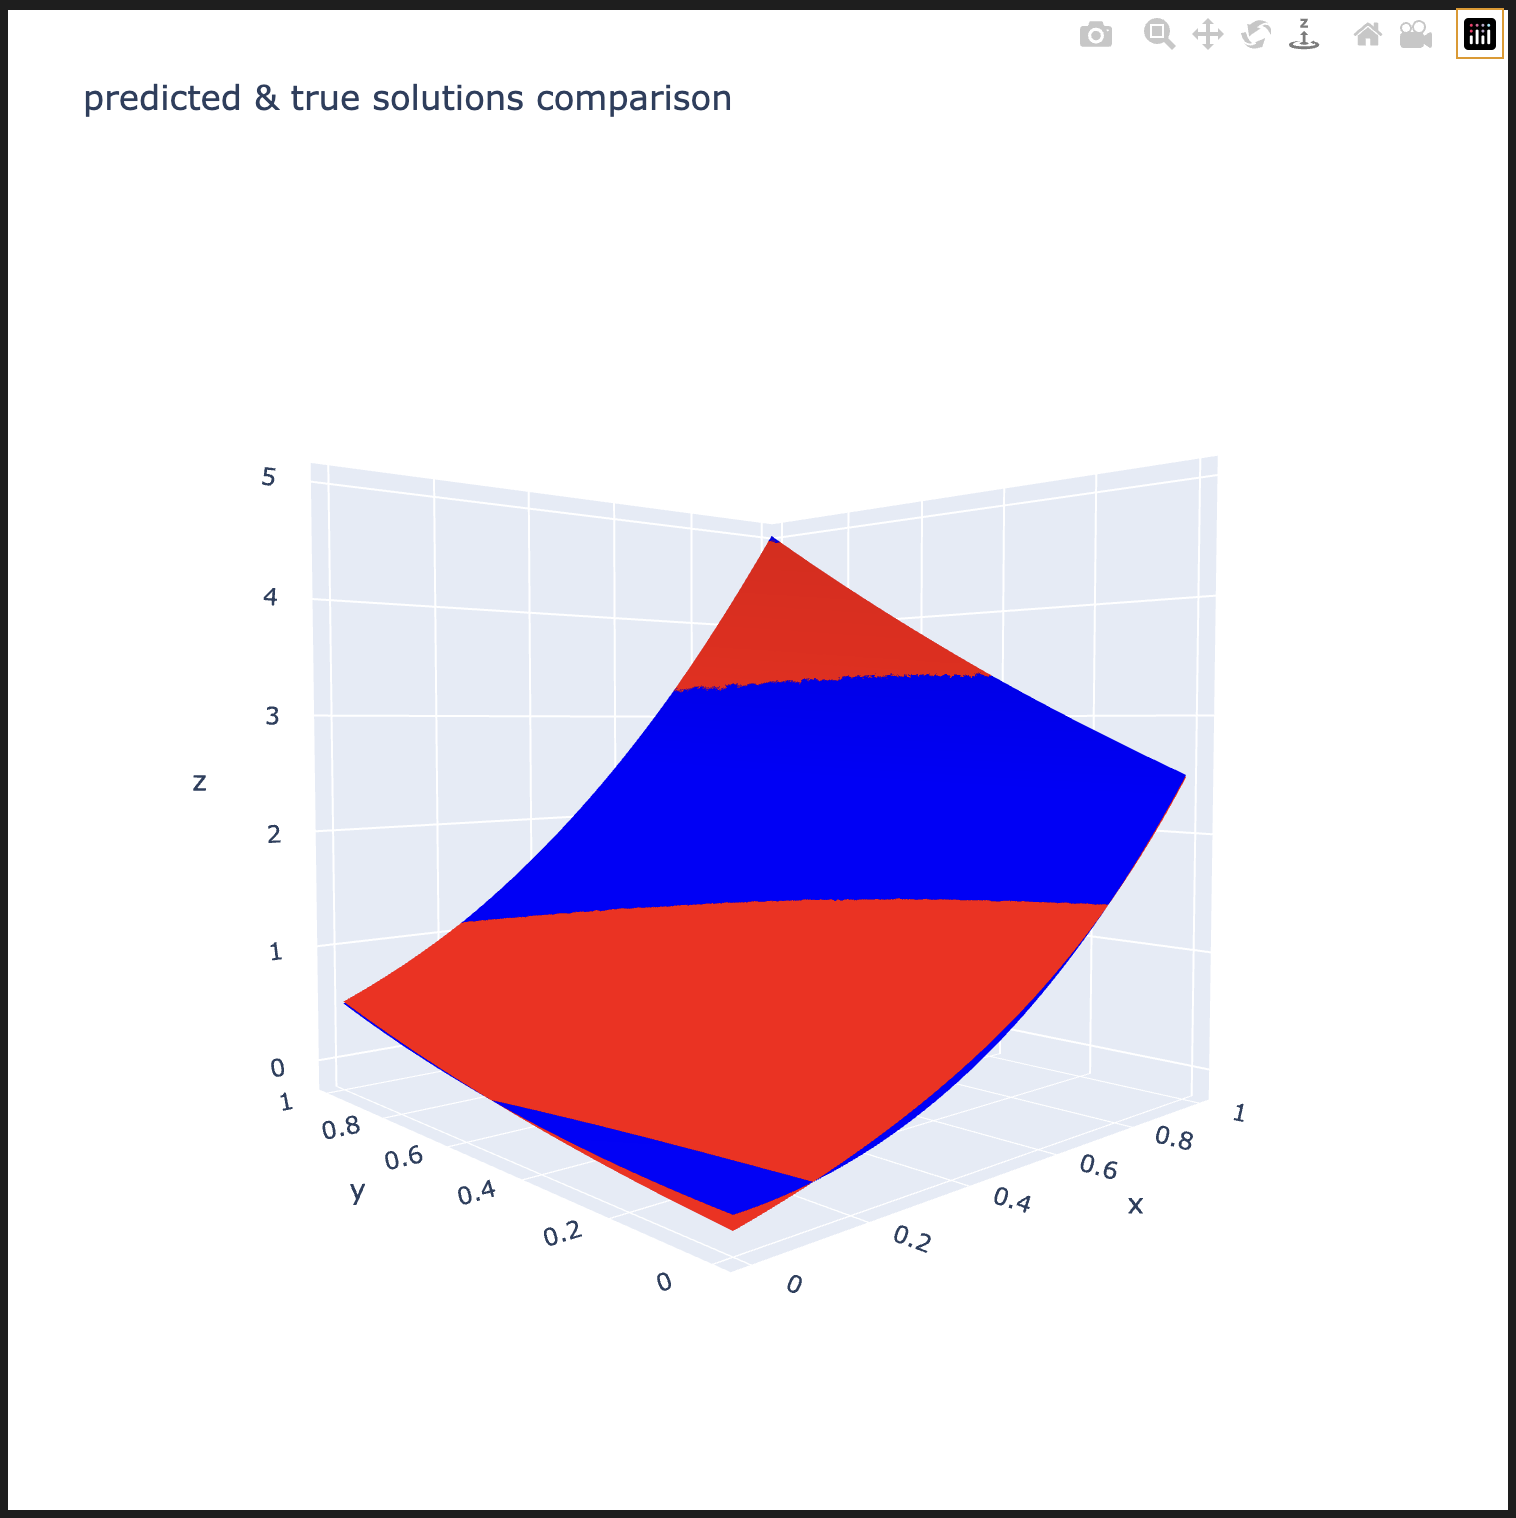

In [41]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]],
    subplot_titles=("predicted solution", "residual distribution", "predicted & true", "error distribution"),
)

fig.add_trace(
    go.Mesh3d(x=df['x'], y=df['y'], z=df['predicted_solution'], intensity=df['predicted_solution'], colorscale='Viridis', colorbar=dict(len=.4, x=0.45 ,y=.81)),
    row=1, col=1
)

fig.add_trace(
    go.Mesh3d(x=df['x'], y=df['y'], z=df['residual'], intensity=df['residual'], colorscale='Viridis', colorbar=dict(len=.4, x=1 ,y=.81)),
    row=1, col=2
)

fig.add_trace(
    go.Mesh3d(x=df['x'], y=df['y'], z=df['predicted_solution'], intensity=df['error'], colorscale='Viridis', colorbar=dict(len=.4, x=0.45 ,y=.19)),
    row=2, col=1
)

fig.add_trace(
    go.Mesh3d(x=df['x'], y=df['y'], z=df['error'], intensity=df['error'], colorscale='Viridis', colorbar=dict(len=.4, x=1 ,y=.19)),
    row=2, col=2
)

fig.update_layout(
    autosize=False,
    width=1250,
    height=1000,
    showlegend=False
)

fig.show()

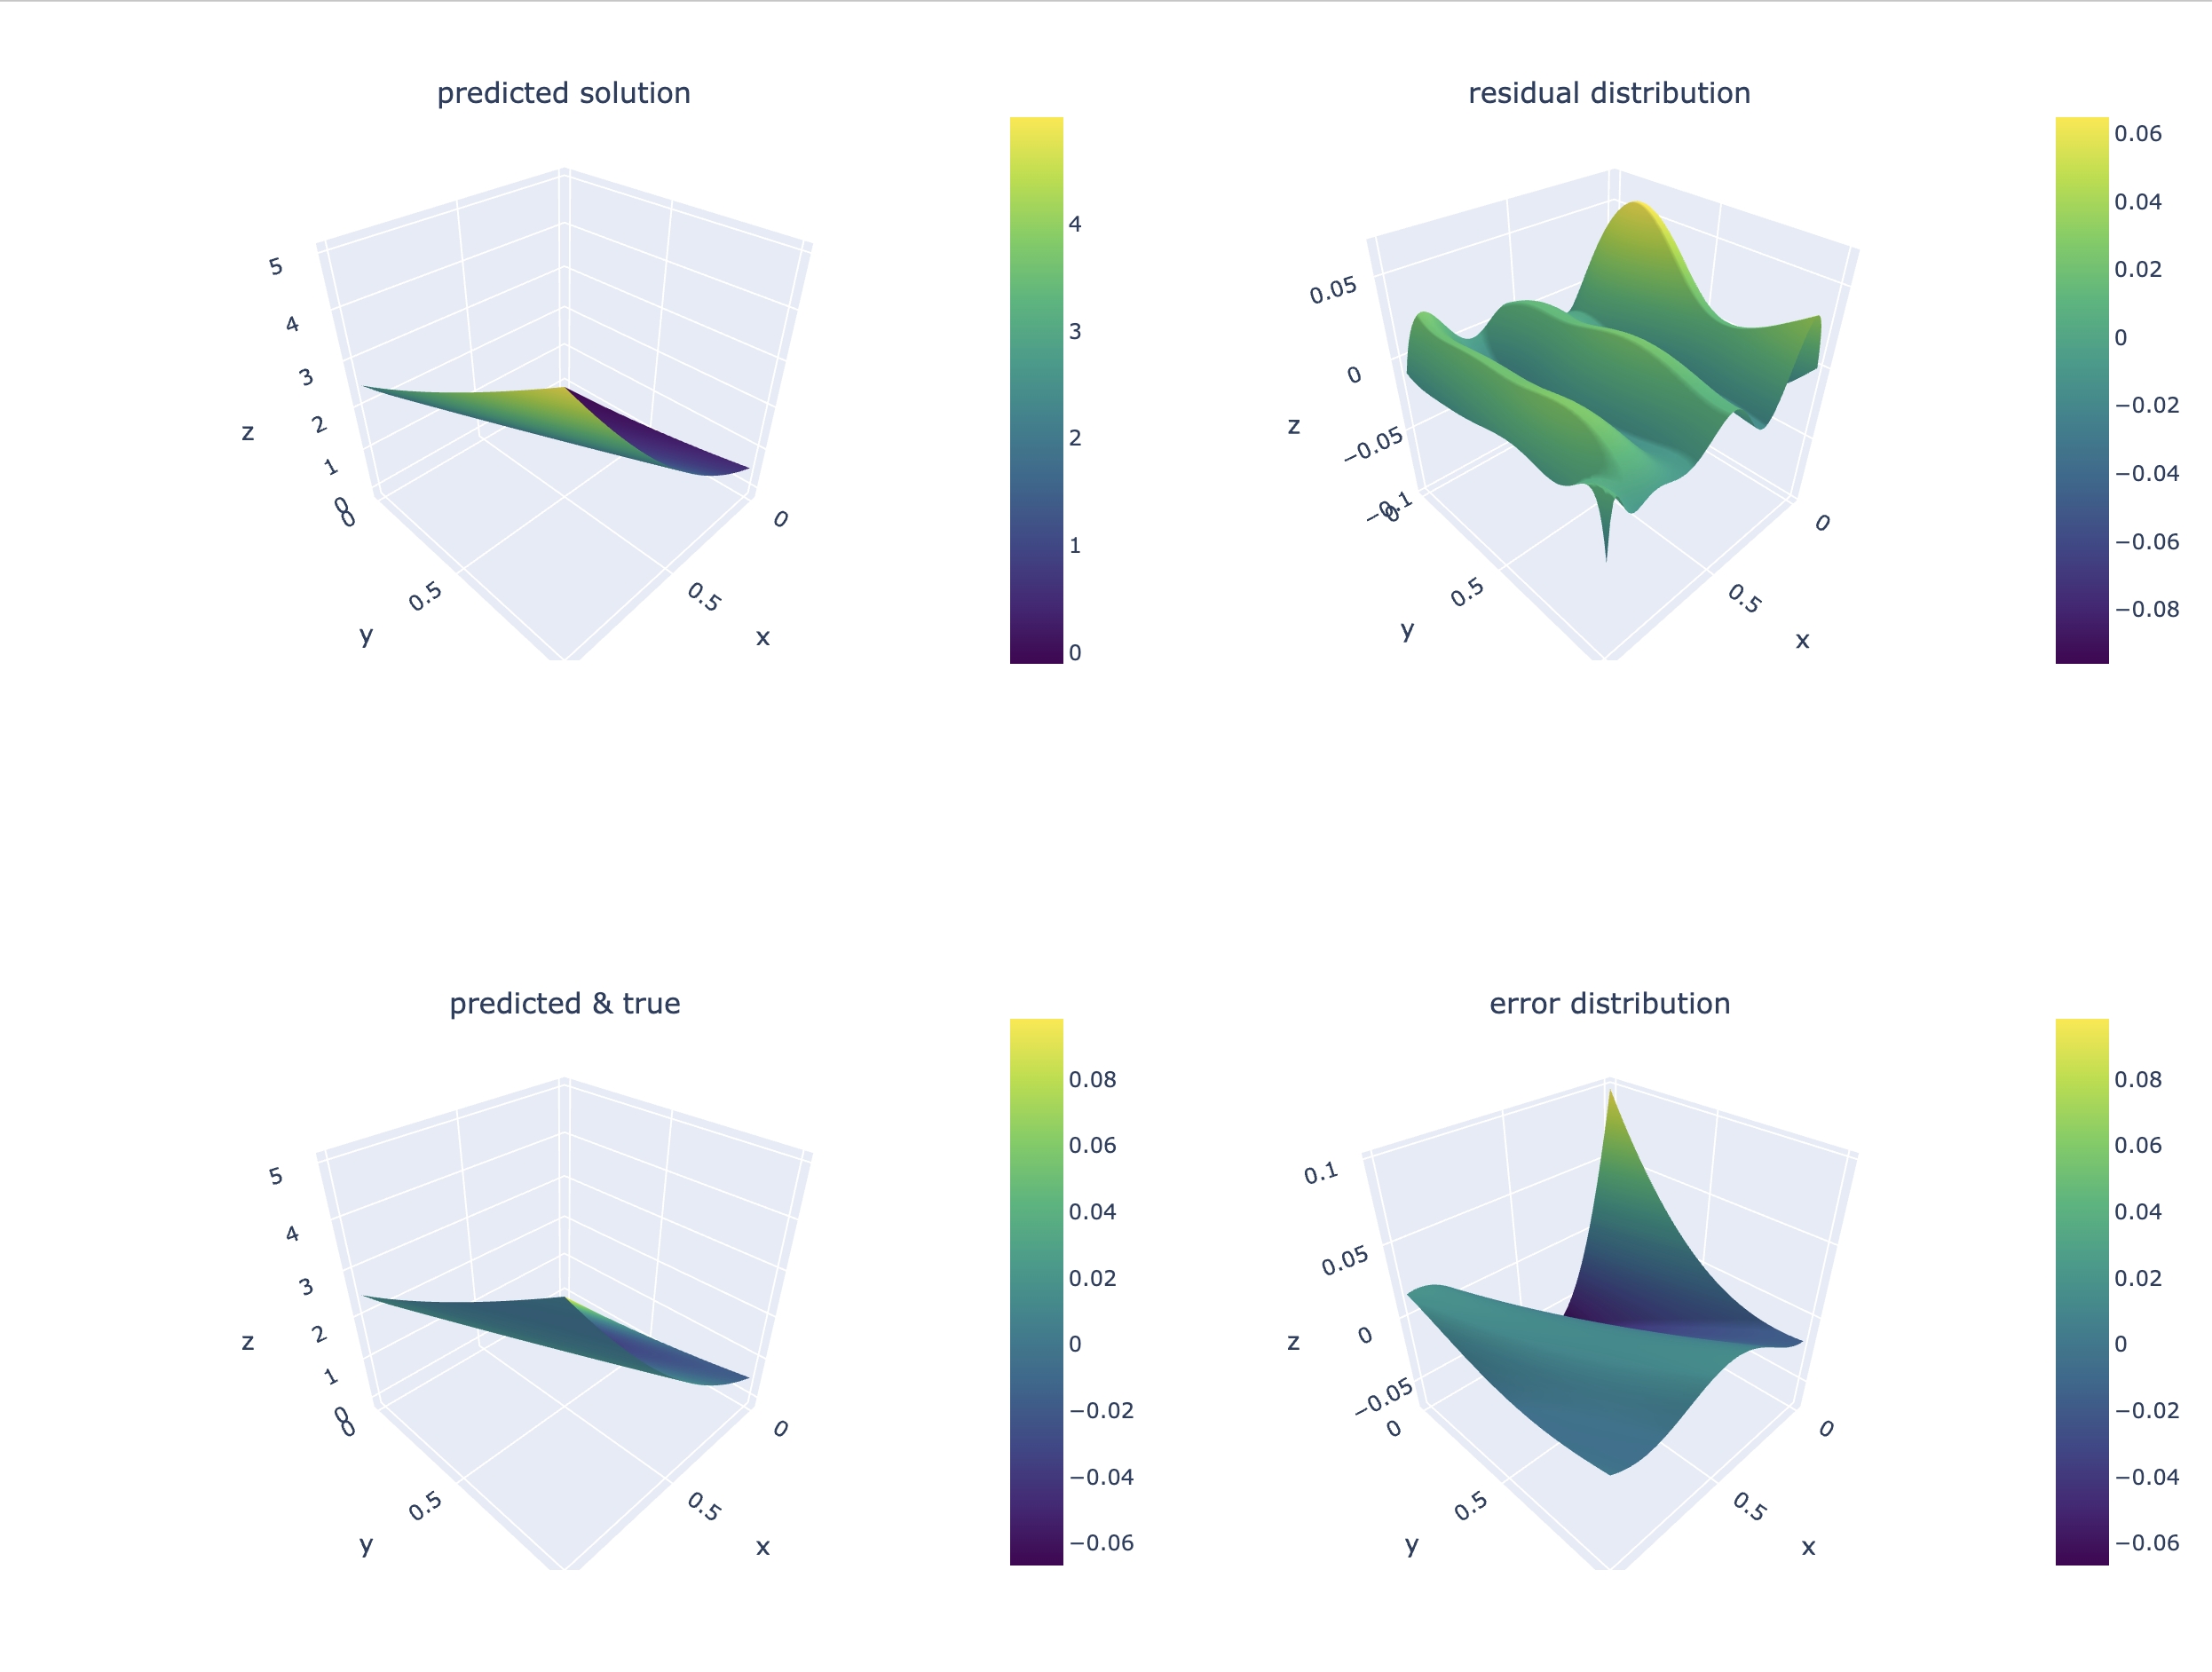